In [1]:
import numpy as np
import copy
from numpy.random import permutation

class Line():
    """
        Linear Model with two weights w0 (intercept) and w1 (slope)
    """
    def __init__(self):
        self.weights = [np.random.uniform(0,1,1) for _ in range(2)]
        self.derivative_funcs = [self.dx_w0, self.dx_w1]

    def evaluate(self,x):
        """
            evaluate: will evaluate the line yhate given x
            x: a point in the plane

            return the result of the function evalutation
        """
        return self.weights[0] + self.weights[1]*x

    def derivate(self, x, y):
        """
            derivate: will calculate all partial derivatives and return them
            input:
            x: a point in the plane
            y: the response of the point x

            output:
            partial_derivatives: an array of partial derivatives
        """
        partial_derivatives = []

        yhat = self.evaluate(x)
        partial_derivatives.append(self.dx_w0(x, y, yhat))
        partial_derivatives.append(self.dx_w1(x, y, yhat))

        return partial_derivatives

    def dx_w0(self, x, y, yhat):
        """
            dx_w0: partial derivative of the weight w0
            x: a point in the plane
            y: the response of the point x
            yhat: the current approximation of y given x and the weights

            return the gradient at that point for this x and y for w0
        """
        return 2*(yhat - y)

    def dx_w1(self, x, y, yhat):
        """
            dx_w1: partial derivative of the weight w1 for a linear function
            x: a point in the plane
            y: the response of the point x
            yhat: the current approximation of y given x and the weights

            return the gradient at that point for this x and y for w1
        """
        return 2*x*(yhat - y)

    def __str__(self):
        return f"y = {self.weights[0]} + {self.weights[1]}*x"


#################### Helper functions ######################
def stochastic_sample(xs, ys):
    """
        stochastic_sample: sample with replacement one x and one y
        xs: all point on the plane
        ys: all response on the plane

        return the randomly selected x and y point
    """
    perm = permutation(len(xs))
    x = xs[perm[0]]
    y = ys[perm[0]]

    return x, y


def gradient(dx, evaluate, xs, ys):
    """
        gradient: estimate mean gradient over all point for w1
        evaluate: the evaulation function from the model
        dx: partial derivative function used to evaluate the gradient
        xs: all point on the plane
        ys: all response on the plane

        return the mean gradient all x and y for w1
    """
    N = len(ys)

    total = 0
    for x,y in zip(xs,ys):
        yhat = evaluate(x)
        total = total + dx(x, y, yhat)

    gradient = total/N
    return gradient

################## Optimization Functions #####################

def gd(model, xs, ys, learning_rate = 0.01, max_num_iteration = 1000):
    """
        gd: will estimate the parameters w1 and w2 (here it uses least square cost function)
        model: the model we are trying to optimize using gradient descent
        xs: all point on the plane
        ys: all response on the plane
        learning_rate: the learning rate for the step that weights update will take
        max_num_iteration: the number of iteration before we stop updating
    """

    for i in range(max_num_iteration):
        # Updating the model parameters
        model.weights = [weight - learning_rate*gradient(derivative_func, model.evaluate, xs, ys) for weight, derivative_func in zip(model.weights, model.derivative_funcs)]

        if i % 100 == 0:
            print(f"Iteration {i}")
            print(model)

def sgd(model, xs, ys, learning_rate = 0.01, max_num_iteration = 1000):
    """
        sgd: will estimate the parameters w0 and w1
        (here it uses least square cost function)
        model: the model we are trying to optimize using sgd
        xs: all point on the plane
        ys: all response on the plane
        learning_rate: the learning rate for the step that weights update will take
        max_num_iteration: the number of iteration before we stop updating
    """

    for i in range(max_num_iteration):

        # Select a random x and y
        x, y = stochastic_sample(xs, ys)

        # Updating the model parameters
        model.weights = [weight - learning_rate*derivative for weight, derivative in zip(model.weights, model.derivate(x,y))]

        if i % 100 == 0:
            print(f"Iteration {i}")
            print(model)

def sgd_momentum(model, xs, ys, learning_rate = 0.01, decay_factor = 0.9, max_num_iteration = 1000):
    """
        sgd_momentum: will estimate the parameters w0 and w1
        (here it uses least square cost function)
        model: the model we are trying to optimize using sgd
        xs: all point on the plane
        ys: all response on the plane
        learning_rate: the learning rate for the step that weights update will take
        decay_factor: determines the relative contribution of the current gradient and earlier gradients to the weight change
        max_num_iteration: the number of iteration before we stop updating
    """

    # Create the gradient that we keep track as an array of 0 of the same size as the number of weights
    gradients = [0 for _ in range(len(model.weights))]

    for i in range(max_num_iteration):

        # Select a random x and y
        x, y = stochastic_sample(xs, ys)

        # Calculate the new gradients
        gradients = [decay_factor*g + learning_rate*derivative for g, derivative in zip(gradients, model.derivate(x,y))]

        # Updating the model parameters
        model.weights = [weight - g for weight, g in zip(model.weights, gradients)]

        if i % 100 == 0:
            print(f"Iteration {i}")
            print(model)


def adagrad(model, xs, ys, learning_rate = 0.1, max_num_iteration = 1000, eps=0.0000001):
    """
        adagrad: will estimate the parameters w0 and w1
        (here it uses least square cost function)
        model: the model we are trying to optimize using sgd
        xs: all point on the plane
        ys: all response on the plane
        learning_rate: the learning rate for the step that weights update will take
        max_num_iteration: the number of iteration before we stop updating
        eps: is a numerical safety to avoid division by 0
    """

    # Here only the diagonal matter
    num_param = len(model.weights)
    G = [[0 for _ in range(num_param)] for _ in range(num_param)]

    for i in range(max_num_iteration):

        # Select a random x and y
        x, y = stochastic_sample(xs, ys)

        # Update G and the model weights iteratively (Note: speed up could be gained from vectorized implementation)
        for idx, gradient in enumerate(model.derivate(x, y)):
            G[idx][idx] = G[idx][idx] + gradient**2
            model.weights[idx] = model.weights[idx] - (learning_rate / np.sqrt(G[idx][idx] + eps)) * gradient

        if i % 100 == 0:
            print(f"Iteration {i}")
            print(model)

def rmsprop(model, xs, ys, learning_rate = 0.01, decay_factor = 0.9, max_num_iteration = 10000, eps=0.0000001):
    """
        rmsprop: will estimate the parameters w0 and w1
        (here it uses least square cost function)
        model: the model we are trying to optimize using sgd
        xs: all point on the plane
        ys: all response on the plane
        learning_rate: the learning rate for the step that weights update will take
        decay_factor: the parameter used in the running averaging
        max_num_iteration: the number of iteration before we stop updating
        eps: is a numerical safety to avoid division by 0
    """

    # Running average
    E = [0 for _ in range(len(model.weights))]

    for i in range(max_num_iteration):

        # Select a random x and y
        x, y = stochastic_sample(xs, ys)

        # Update E and the model weights iteratively (Note: speed up could be gained from vectorized implementation)
        for idx, gradient in enumerate(model.derivate(x, y)):
            E[idx] = decay_factor*E[idx] + (1 - decay_factor)*(gradient**2)
            model.weights[idx] = model.weights[idx] - (learning_rate/np.sqrt(E[idx] + eps))*gradient


        if i % 100 == 0:
            print(f"Iteration {i}")
            print(model)

def adadelta(model, xs, ys, decay_factor = 0.9, max_num_iteration = 10000, eps=0.0000001):
    """
        Adadelta: will estimate the parameters w0 and w1
        model: the model we are trying to optimize using sgd
        xs: all point on the plane
        ys: all response on the plane
        decay_factor: the parameter used in the running averaging
        max_num_iteration: the number of iteration before we stop updating
        eps: is a numerical safety to avoid division by 0
    """

    # Init Running Averages
    num_param = len(model.weights)
    E_g = [0 for _ in range(num_param)]
    E_p = [0 for _ in range(num_param)]
    delta_p = [0 for _ in range(num_param)]


    for i in range(max_num_iteration):

        # Select a random x and y
        x, y = stochastic_sample(xs, ys)

        for idx, gradient in enumerate(model.derivate(x, y)):
            # Get the running average for the gradient
            E_g[idx] = decay_factor*E_g[idx] + (1 - decay_factor)*(gradient**2)

            # Get the running average for the parameters
            E_p[idx] = decay_factor*E_p[idx] + (1 - decay_factor)*(delta_p[idx]**2)

            # Calculate the gradient difference
            delta_p[idx] = - np.sqrt(E_p[idx] + eps) / np.sqrt(E_g[idx] + eps) * gradient

            # update the model weight
            model.weights[idx] = model.weights[idx] + delta_p[idx]


        if i % 100 == 0:
            print(f"Iteration {i}")
            print(model)


def adam(model, xs, ys, learning_rate = 0.1, b1 = 0.9, b2 = 0.999, epsilon = 0.00000001, max_iteration = 1000):
    """
        Adam: This is the adam optimizer that build upon adadelta and RMSProp
        model: The model we want to optimize the parameter on
        xs: the feature of my dataset
        ys: the continous value (target)
        learning_rate: the amount of learning we want to happen at each time step (default is 0.1 and will be updated by the optimizer)
        b1: this is the first decaying average with proposed default value of 0.9 (deep learning purposes)
        b2: this is the second decaying average with proposed default value of 0.999 (deep learning purposes)
        epsilon: a variable for numerical stability during the division
        max_iteration: the number of sgd round we want to do before stopping the optimization
    """


    # Variable Initialization
    num_param = len(model.weights)
    m = [0 for _ in range(num_param)] # two m for each parameter
    v = [0 for _ in range(num_param)] # two v for each parameter
    g = [0 for _ in range(num_param)] # two gradient

    for t in range(1,max_iteration):

        # Calculate the gradients
        x, y = stochastic_sample(xs, ys)

        # Get the partial derivatives
        g = model.derivate(x, y)

        # Update the m and v parameter
        m = [b1*m_i + (1 - b1)*g_i for m_i, g_i in zip(m, g)]
        v = [b2*v_i + (1 - b2)*(g_i**2) for v_i, g_i in zip(v, g)]

        # Bias correction for m and v
        m_cor = [m_i / (1 - (b1**t)) for m_i in m]
        v_cor = [v_i / (1 - (b2**t)) for v_i in v]

        # Update the parameter
        model.weights = [weight - (learning_rate / (np.sqrt(v_cor_i) + epsilon))*m_cor_i for weight, v_cor_i, m_cor_i in zip(model.weights, v_cor, m_cor)]

        if t % 100 == 0:
            print(f"Iteration {t}")
            print(model)

def nesterov(model, xs, ys, learning_rate = 0.01, decay_factor = 0.9, max_num_iteration = 1000):
    """
        Nesterov: This is the nesterov accelerated gradient optimizer that build upon momentum
        model: the model we want to optimize the parameter on (this is a line right now)
        xs: the feature of my dataset
        ys: the continous value (target)
        learning_rate: the learning rate for the step that weights update will take
        decay_factor: determines the relative contribution of the current gradient and earlier gradients to the weight change
        max_num_iteration: the number of iteration before we stop updating
    """

    # These are needed to keep track of the previous gradient
    g = [0 for _ in range(len(model.weights))]

    for i in range(max_num_iteration):

        # Select a random x and y
        x, y = stochastic_sample(xs, ys)

        # Calculate the gradient for w0 by predicting where the ball will be (approximatively)
        for idx, gradient in enumerate(model.derivate(x,y)):

            # Here we need to do a bit of gymnastic because of how the code is setup
            # We need to save the parameters state, modify it, do the simulation and then reset the parameter state
            # The update happen in the next section
            prev_weight = model.weights[idx]
            model.weights[idx] = decay_factor*gradient
            g[idx] = decay_factor*g[idx] + learning_rate*gradient
            model.weights[idx] = prev_weight

            # Update the model parameter
            model.weights[idx] = model.weights[idx] - g[idx]

        if i % 100 == 0:
            print(f"Iteration {i}")
            print(model)


def adamax(model, xs, ys, learning_rate = 0.1, b1 = 0.9, b2 = 0.999, max_iteration = 1000):
    """
        Adamax: This is the adamax optimizer that build upong adam with L_inf norm
        model: The model we want to optimize the parameter on
        xs: the feature of my dataset
        ys: the continous value (target)
        learning_rate: the amount of learning we want to happen at each time step (default is 0.1 and will be updated by the optimizer)
        b1: this is the first decaying average with proposed default value of 0.9 (deep learning purposes)
        b2: this is the second decaying average with proposed default value of 0.999 (deep learning purposes)
        max_iteration: the number of sgd round we want to do before stopping the optimization
    """


    # Variable Initialization
    num_param = len(model.weights)
    m = [0 for _ in range(num_param)] # two m for each parameter
    v = [0 for _ in range(num_param)] # two v for each parameter
    g = [0 for _ in range(num_param)] # two gradient

    for t in range(1,max_iteration):

        # Calculate the gradients
        x, y = stochastic_sample(xs, ys)

        # Get the partial derivatives
        g = model.derivate(x, y)

        # Update the m and v parameter
        m = [b1*m_i + (1 - b1)*g_i for m_i, g_i in zip(m, g)]
        v = [np.maximum(b2*v_i, np.absolute(g_i)) for v_i, g_i in zip(v, g)]

        # Bias correction for m only
        m_cor = [m_i / (1 - (b1**t)) for m_i in m]

        # Update the parameter
        model.weights = [weight - (learning_rate / np.sqrt(v_i))*m_cor_i for weight, v_i, m_cor_i in zip(model.weights, v, m_cor)]

        if t % 100 == 0:
            print(f"Iteration {t}")
            print(model)

def nadam(model, xs, ys, learning_rate = 0.1, b1 = 0.9, b2 = 0.999, epsilon = 0.00000001, max_iteration = 1000):
    """
        Nadam: This is the adam optimizer that build upon adadelta and RMSProp with Nesterov Accelerated Gradient sprinkled on top
        model: The model we want to optimize the parameter on
        xs: the feature of my dataset
        ys: the continous value (target)
        learning_rate: the amount of learning we want to happen at each time step (default is 0.1 and will be updated by the optimizer)
        b1: this is the first decaying average with proposed default value of 0.9 (deep learning purposes)
        b2: this is the second decaying average with proposed default value of 0.999 (deep learning purposes)
        epsilon: a variable for numerical stability during the division
        max_iteration: the number of sgd round we want to do before stopping the optimization
    """


    # Variable Initialization
    num_param = len(model.weights)
    m = [0 for _ in range(num_param)] # two m for each parameter
    v = [0 for _ in range(num_param)] # two v for each parameter
    g = [0 for _ in range(num_param)] # two gradient

    for t in range(1,max_iteration):

        # Calculate the gradients
        x, y = stochastic_sample(xs, ys)

        # Get the partial derivatives
        g = model.derivate(x, y)

        # Update the m and v parameter
        m = [b1*m_i + (1 - b1)*g_i for m_i, g_i in zip(m, g)]
        v = [b2*v_i + (1 - b2)*(g_i**2) for v_i, g_i in zip(v, g)]

        # Bias correction for m and v
        m_cor = [m_i / (1 - (b1**t)) for m_i in m]
        v_cor = [v_i / (1 - (b2**t)) for v_i in v]

        # nesterov look-ahead gradient
        nag_g = [b1*m_cor_i + ((1-b1) * g_i)/(1 - b1**t) for m_cor_i, g_i in zip(m_cor, g)]

        # Update the parameter
        model.weights = [weight - (learning_rate / (np.sqrt(v_cor_i) + epsilon))*nag_g_i for weight, v_cor_i, nag_g_i in zip(model.weights, v_cor, nag_g)]

        if t % 100 == 0:
            print(f"Iteration {t}")
            print(model)

# Here we have a simple line with intercept = 0 and slope = 2
xs = [1,2,3,4,5,6,7]
ys = [2,4,6,8,10,12,14]

print("Target: intercept = 0 and slope = 2")


# Gradient Descent
model = Line()
print("Gradient Descent: ")
gd(model, xs, ys)
print(model)

# Stochastic Gradient Descent
model = Line()
print("Stochastic Gradient Descent: ")
sgd(model, xs, ys)
print(model)

# Stochastic Gradient Descent with Momentum
model = Line()
print("\nSGD + Momentum: ")
sgd_momentum(model, xs, ys)
print(model)

# Adagrad
model = Line()
print("\nAdagrad")
adagrad(model, xs, ys)
print(model)

# RMSprop
model = Line()
print("\nRMSprop")
rmsprop(model, xs, ys)
print(model)

# Adadelta
model = Line()
print("\nAdadelta")
adadelta(model, xs, ys)
print(model)

# Adam
model = Line()
print("\nAdam")
adam(model, xs, ys)


print(model)

# Nesterov Accelerated Gradient
model = Line()
print("\nNesterov Accelerated Gradient")
nesterov(model, xs, ys)
print(model)

# Adamax
model = Line()
print("\nAdamax")
adamax(model, xs, ys)
print(model)


# Nadam
model = Line()
print("\nNadam")
nadam(model, xs, ys)
print(model)


Target: intercept = 0 and slope = 2
Gradient Descent: 
Iteration 0
y = [0.90359029] + [0.88761217]*x
Iteration 100
y = [0.73746543] + [1.85107548]*x
Iteration 200
y = [0.50170201] + [1.89868579]*x
Iteration 300
y = [0.34131079] + [1.93107535]*x
Iteration 400
y = [0.23219571] + [1.95311016]*x
Iteration 500
y = [0.15796409] + [1.96810057]*x
Iteration 600
y = [0.10746389] + [1.97829863]*x
Iteration 700
y = [0.07310831] + [1.98523643]*x
Iteration 800
y = [0.04973601] + [1.98995626]*x
Iteration 900
y = [0.03383569] + [1.99316719]*x
y = [0.02310746] + [1.99533366]*x
Stochastic Gradient Descent: 
Iteration 0
y = [0.23568893] + [1.11605646]*x
Iteration 100
y = [0.30955244] + [1.95577822]*x
Iteration 200
y = [0.21175885] + [1.9640467]*x
Iteration 300
y = [0.14667161] + [1.97372072]*x
Iteration 400
y = [0.10100454] + [1.98164693]*x
Iteration 500
y = [0.06801219] + [1.98591865]*x
Iteration 600
y = [0.0427289] + [1.98964973]*x
Iteration 700
y = [0.02752491] + [1.99606787]*x
Iteration 800
y = [0.01

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Generate some random data
np.random.seed(42)
X = np.random.rand(100, 1)
y = 2 + 3 * X + np.random.randn(100, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model on the training set
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the training set and calculate the mean squared error
y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)

# Predict on the test set and calculate the mean squared error
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Training set MSE: {mse_train:.2f}")
print(f"Test set MSE: {mse_test:.2f}")

Training set MSE: 0.85
Test set MSE: 0.65


In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
np.random.seed(0)
plt.style.use('ggplot')

In [7]:
iris = load_iris()
X, y = iris.data, iris.target

In [9]:
kf = KFold(n_splits=20)
list_training_error = []
list_testing_error = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = MLPRegressor()
    model.fit(X_train, y_train)
    y_train_data_pred = model.predict(X_train)
    y_test_data_pred = model.predict(X_test)
    fold_training_error = mean_absolute_error(y_train, y_train_data_pred)
    fold_testing_error = mean_absolute_error(y_test, y_test_data_pred)
    list_training_error.append(fold_training_error)
    list_testing_error.append(fold_testing_error)

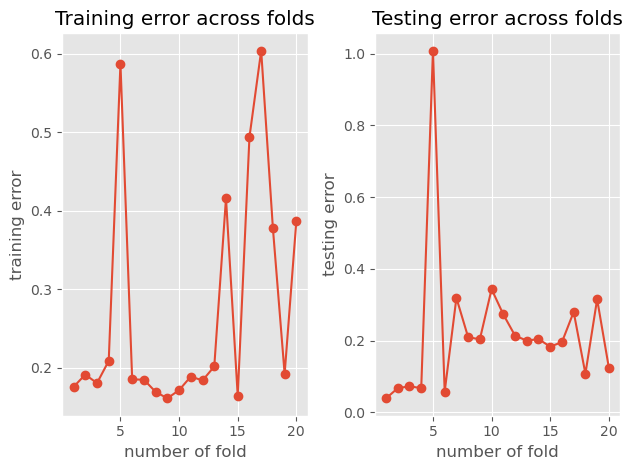

In [11]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('testing error')
plt.title('Testing error across folds')
plt.tight_layout()

plt.show()

